In [ ]:
import numpy as np
import time
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from timeit import default_timer as timer
from scipy.optimize import curve_fit
import decimal


np.random.seed(404)

**Theoretic time complexity estimators**

In [ ]:
def const_theor(x, a):
    return a * np.ones_like(x)

def linear_theor(x, a):
    return a * x

def quad_theor(x, a):
    return a * x ** 2

def n27_theor(x, a):
    return a * x ** 2.7

def cubic_theor(x, a):
    return a * x ** 3

def nlogn_theor(x, a):
    return a * x * np.log(x)

def quadlogn_theor(x, a):
    return a * x * x 

**Naive matrix multiplication implementation**

In [ ]:
def matrix_product(A, B):
    n = len(A)
    C = [[0 for i in range(n)] for j in range(n)]
    for i in range(n):
        for k in range(n):
            for j in range(n):
                C[i][j] += A[i][k] * B[k][j]
    return C


def add(A, B):
    n = len(A)
    C = [[0 for j in range(0, n)] for i in range(0, n)]
    for i in range(0, n):
        for j in range(0, n):
            C[i][j] = A[i][j] + B[i][j]
    return C


def subtract(A, B):
    n = len(A)
    C = [[0 for j in range(0, n)] for i in range(0, n)]
    for i in range(0, n):
        for j in range(0, n):
            C[i][j] = A[i][j] - B[i][j]
    return C

**Strassen's matrix multiplication**

In [ ]:
LEAF_SIZE = 8

def strassenR(A, B):
    """
    Implementation of the strassen algorithm, similar to
    http://en.wikipedia.org/w/index.php?title=Strassen_algorithm&oldid=498910018#Source_code_of_the_Strassen_algorithm_in_C_language
    """
    n = len(A)

    if n <= LEAF_SIZE:
        return matrix_product(A, B)
    else:
        # initializing the new sub-matrices
        new_size = n // 2
        a11 = [[0 for j in range(0, new_size)] for i in range(0, new_size)]
        a12 = [[0 for j in range(0, new_size)] for i in range(0, new_size)]
        a21 = [[0 for j in range(0, new_size)] for i in range(0, new_size)]
        a22 = [[0 for j in range(0, new_size)] for i in range(0, new_size)]

        b11 = [[0 for j in range(0, new_size)] for i in range(0, new_size)]
        b12 = [[0 for j in range(0, new_size)] for i in range(0, new_size)]
        b21 = [[0 for j in range(0, new_size)] for i in range(0, new_size)]
        b22 = [[0 for j in range(0, new_size)] for i in range(0, new_size)]

        aResult = [[0 for j in range(0, new_size)] for i in range(0, new_size)]
        bResult = [[0 for j in range(0, new_size)] for i in range(0, new_size)]

        # dividing the matrices in 4 sub-matrices:
        for i in range(0, new_size):
            for j in range(0, new_size):
                a11[i][j] = A[i][j]  # top left
                a12[i][j] = A[i][j + new_size]  # top right
                a21[i][j] = A[i + new_size][j]  # bottom left
                a22[i][j] = A[i + new_size][j + new_size]  # bottom right

                b11[i][j] = B[i][j]  # top left
                b12[i][j] = B[i][j + new_size]  # top right
                b21[i][j] = B[i + new_size][j]  # bottom left
                b22[i][j] = B[i + new_size][j + new_size]  # bottom right

        # Calculating p1 to p7:
        aResult = add(a11, a22)
        bResult = add(b11, b22)
        p1 = strassenR(aResult, bResult)  # p1 = (a11+a22) * (b11+b22)

        aResult = add(a21, a22)  # a21 + a22
        p2 = strassenR(aResult, b11)  # p2 = (a21+a22) * (b11)

        bResult = subtract(b12, b22)  # b12 - b22
        p3 = strassenR(a11, bResult)  # p3 = (a11) * (b12 - b22)

        bResult = subtract(b21, b11)  # b21 - b11
        p4 = strassenR(a22, bResult)  # p4 = (a22) * (b21 - b11)

        aResult = add(a11, a12)  # a11 + a12
        p5 = strassenR(aResult, b22)  # p5 = (a11+a12) * (b22)

        aResult = subtract(a21, a11)  # a21 - a11
        bResult = add(b11, b12)  # b11 + b12
        p6 = strassenR(aResult, bResult)  # p6 = (a21-a11) * (b11+b12)

        aResult = subtract(a12, a22)  # a12 - a22
        bResult = add(b21, b22)  # b21 + b22
        p7 = strassenR(aResult, bResult)  # p7 = (a12-a22) * (b21+b22)

        # calculating c21, c21, c11 e c22:
        c12 = add(p3, p5)  # c12 = p3 + p5
        c21 = add(p2, p4)  # c21 = p2 + p4

        aResult = add(p1, p4)  # p1 + p4
        bResult = add(aResult, p7)  # p1 + p4 + p7
        c11 = subtract(bResult, p5)  # c11 = p1 + p4 - p5 + p7

        aResult = add(p1, p3)  # p1 + p3
        bResult = add(aResult, p6)  # p1 + p3 + p6
        c22 = subtract(bResult, p2)  # c22 = p1 + p3 - p2 + p6

        # Grouping the results obtained in a single matrix:
        C = [[0 for j in range(0, n)] for i in range(0, n)]
        for i in range(0, new_size):
            for j in range(0, new_size):
                C[i][j] = c11[i][j]
                C[i][j + new_size] = c12[i][j]
                C[i + new_size][j] = c21[i][j]
                C[i + new_size][j + new_size] = c22[i][j]
        return C


def strassen(A, B):
    # Make the matrices bigger so that you can apply the strassen
    # algorithm recursively without having to deal with odd
    # matrix sizes
    nextPowerOfTwo = lambda n: 2 ** int(np.ceil(np.math.log(n, 2)))
    n = len(A)
    m = nextPowerOfTwo(n)
    APrep = [[0 for i in range(m)] for j in range(m)]
    BPrep = [[0 for i in range(m)] for j in range(m)]
    for i in range(n):
        for j in range(n):
            APrep[i][j] = A[i][j]
            BPrep[i][j] = B[i][j]
    CPrep = strassenR(APrep, BPrep)
    C = [[0 for i in range(n)] for j in range(n)]
    for i in range(n):
        for j in range(n):
            C[i][j] = CPrep[i][j]
    return C

**Time measurements (average for set amount of runs)**

In [ ]:
def avg_runs(runs, experiments, fun):
    times = []
    for i in range(runs):
        times.append([])
        for j in tqdm(range(1, experiments + 1)):
            v = np.random.rand(j)
            start_time = timer()
            fun(v)
            times[i].append(timer() - start_time)
            
    return np.array(times, dtype=np.float64).mean(axis=0)

In [ ]:
def avg_runs_matrix(runs, experiments, fun):
    times = []
    for i in range(runs):
        times.append([])
        for j in tqdm(range(1, experiments + 1)):
            mat_a = np.random.rand(j, j)
            mat_b = np.random.rand(j, j)
            start_time = timer()
            fun(mat_a, mat_b)
            times[i].append(timer() - start_time)
            
    return np.array(times, dtype=np.float64).mean(axis=0)

**Plotting**

In [ ]:
def plot(title, emp_time, estimator):
    if estimator == nlogn_theor:
        xdata = np.linspace(1, len(emp_time), len(emp_time)-1, dtype=np.float64)
        ydata = np.array(emp_time, dtype=np.float64)
        popt, _ = curve_fit(estimator, xdata, ydata[1:])
    else:
        xdata = np.arange(len(emp_time), dtype=np.float64)
        ydata = np.array(emp_time, dtype=np.float64)
        popt, _ = curve_fit(estimator, xdata, ydata)

    plt.plot(emp_time)
    plt.plot(xdata, estimator(xdata, *popt), 'r-',
             label='fit: a=%5.3f, ' % tuple(popt))
    plt.grid(True)
    plt.title(f"{title} time measurements")
    plt.legend(["Theoretical", "Empirical"])
    plt.show()

In [ ]:
j = 10
mat_a = np.random.rand(j, j)
            mat_b = np.random.rand(j, j)

**Test runs and time comparison**

In [ ]:
avg_time_nai_100 = avg_runs_matrix(1, 100, matrix_product)
avg_time_str_100 = avg_runs_matrix(1, 100, strassen)


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


In [ ]:
avg_time_nai_200 = avg_runs_matrix(1, 200, matrix_product)
avg_time_str_200 = avg_runs_matrix(1, 200, strassen)

In [ ]:
avg_time_nai_256 = avg_runs_matrix(1, 256, matrix_product)
avg_time_str_256 = avg_runs_matrix(1, 256, strassen)

100%|██████████| 100/100 [00:26<00:00,  3.74it/s]


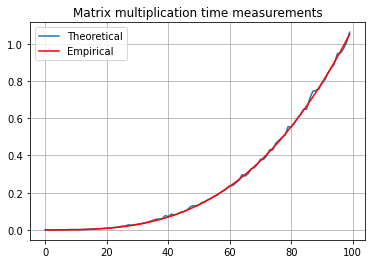

In [ ]:
plot("Matrix multiplication", avg_time_nai_100, cubic_theor)

100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


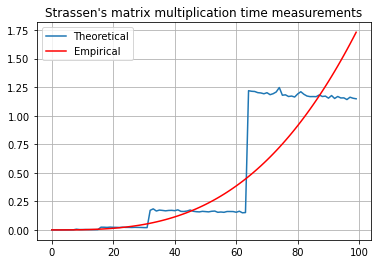

In [ ]:
plot("Strassen's matrix multiplication", avg_time_str_100, cubic_theor)

**Johnson’s algorithm for sparse graphs**

True
True


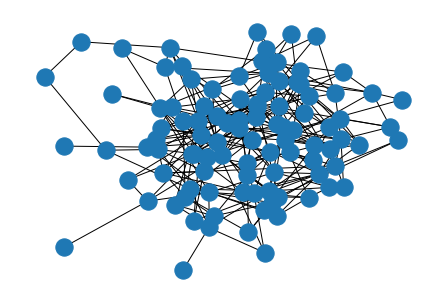

In [ ]:
seed=359

n = 100
m = 260

g = nx.gnm_random_graph(n, m, seed=seed)
weights = np.random.randint(100, size=m)
for i, elem in enumerate(g.edges()):
    g[elem[0]][elem[1]]['weight'] = weights[i]
    g[elem[1]][elem[0]]['weight'] = weights[i]
print(np.all(nx.linalg.graphmatrix.adjacency_matrix(g).toarray() == nx.linalg.graphmatrix.adjacency_matrix(g).toarray().T))
print(np.all(nx.linalg.graphmatrix.adjacency_matrix(g).toarray() >= 0))
nx.draw(g)

In [ ]:
paths = nx.algorithms.shortest_paths.johnson(g, 'weight')
print(paths[2][64])

[2, 70, 58, 7, 64]


In [ ]:
def measure_jhn_time(runs, experiments):
    times = []
    shift = 2
    edges_multiplier = 3
    for i in range(runs):
        times.append([])
        for j in tqdm(range(shift, experiments + shift)):
            nodes = j
            m = int(np.ceil(edges_multiplier * j))

            gr = nx.gnm_random_graph(nodes, m)
            weights = np.random.randint(nodes , size=m)
            for k, elem in enumerate(gr.edges()):
                gr[elem[0]][elem[1]]['weight'] = weights[k]
                gr[elem[1]][elem[0]]['weight'] = weights[k]
            start_time = timer()
            nx.algorithms.shortest_paths.johnson(gr, 'weight')
            times[i].append(timer() - start_time)

    return np.array(times, dtype=np.float64).mean(axis=0)

100%|██████████| 300/300 [01:57<00:00,  2.55it/s]


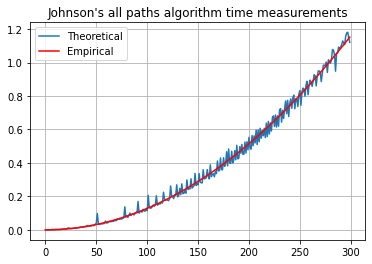

In [ ]:
avg_time_jhn = measure_jhn_time(1, 300)
plot("Johnson's all paths algorithm", avg_time_jhn, quad_theor)

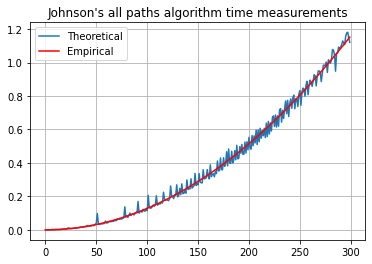

In [ ]:
plot("Johnson's all paths algorithm", avg_time_jhn, quad_theor)

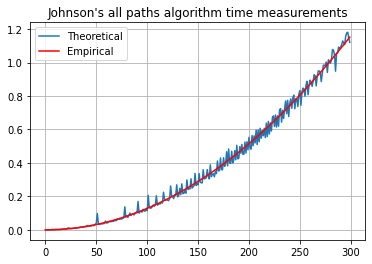

In [ ]:
plot("Johnson's all paths algorithm", avg_time_jhn, quadlogn_theor)

In [ ]:
def measure_jhn_time_shift(runs, experiments, shift):
    times = []
    edges_multiplier = 3
    for i in range(runs):
        times.append([])
        for j in tqdm(range(shift, experiments + shift)):
            nodes = j
            m = int(np.ceil(edges_multiplier * j))

            gr = nx.gnm_random_graph(nodes, m)
            weights = np.random.randint(nodes , size=m)
            for k, elem in enumerate(gr.edges()):
                gr[elem[0]][elem[1]]['weight'] = weights[k]
                gr[elem[1]][elem[0]]['weight'] = weights[k]
            start_time = timer()
            nx.algorithms.shortest_paths.johnson(gr, 'weight')
            times[i].append(timer() - start_time)

    return np.array(times, dtype=np.float64).mean(axis=0)

100%|██████████| 1/1 [00:03<00:00,  3.59s/it]
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


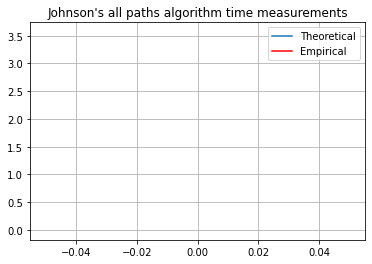

In [ ]:
avg_time_jhn_1 = measure_jhn_time_shift(1, 1, 500)
plot("Johnson's all paths algorithm", avg_time_jhn_1, quad_theor)